In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
try:
    # Connect to an existing database
    connection = psycopg2.connect(database="2022-everything-team12", 
                            user='xst2267', 
                            password='password', 
                            host='pg.analytics.northwestern.edu', 
                            port= '5432')

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
df = pd.read_sql("select * from \"aggtrnsactdaily2\"", connection);
if (connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed") 

You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 



/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


PostgreSQL connection is closed


In [3]:
# data preprocessing
df.sort_values(by=['saledate'],inplace=True)
df = df.set_index('saledate')
df.index = pd.to_datetime(df.index)
df.head(5)

,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,avgorigprice,...,maxdiscount,totalprofit,avgprofittrnsact,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323,61741,188073,783,6035654.36,25148.559833,0.0,895.0,4467905.60,23.756231,...,118.5,511060.0,2129.418229,0.0,275.0,323,262,58,852,2
2004-08-02,324,59183,177143,208,5637192.49,6624.197991,0.0,1200.0,4174584.51,23.566184,...,325.0,532033.0,625.185444,0.0,359.0,324,263,58,827,2
2004-08-03,324,62593,212625,233,6569613.74,7219.355758,0.0,895.0,4833202.76,22.731112,...,119.0,659895.0,725.159066,0.0,393.0,324,263,58,842,2
2004-08-04,324,65689,218053,241,6874637.33,7604.687312,0.0,895.0,4974026.91,22.811091,...,275.0,631430.0,698.484375,0.0,393.0,324,263,58,843,2
2004-08-05,325,68941,225237,289,7913489.50,10184.671171,0.0,1200.0,5501540.60,24.425563,...,275.0,635209.0,817.514640,0.0,393.0,325,263,58,870,2


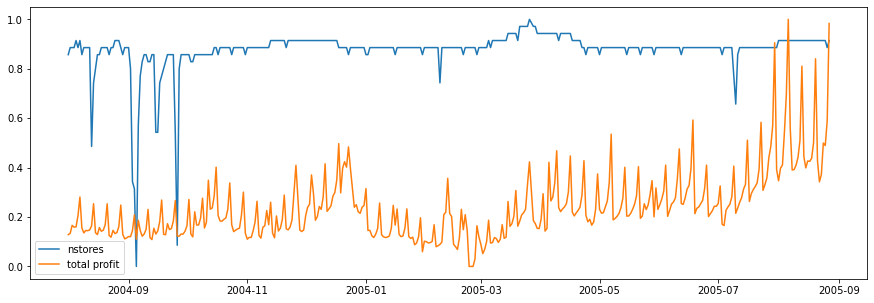

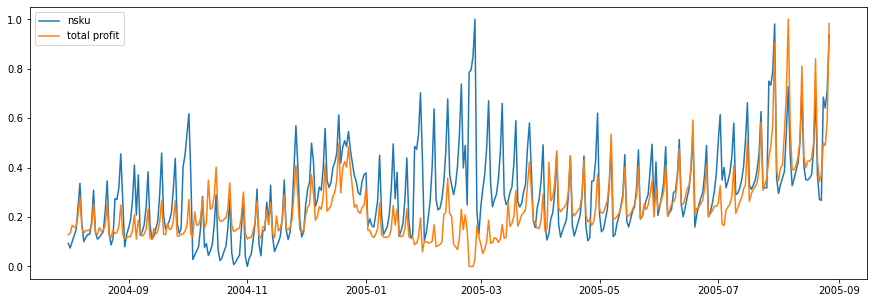

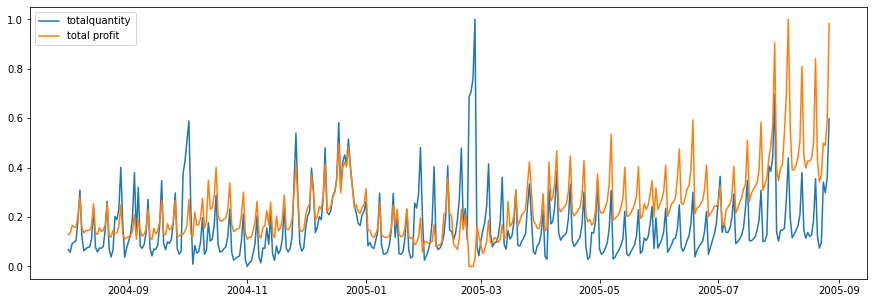

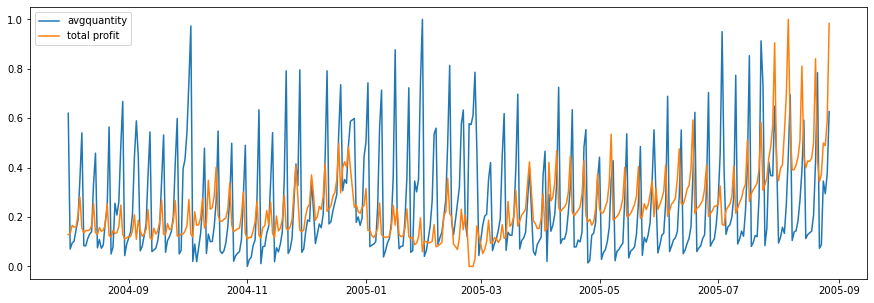

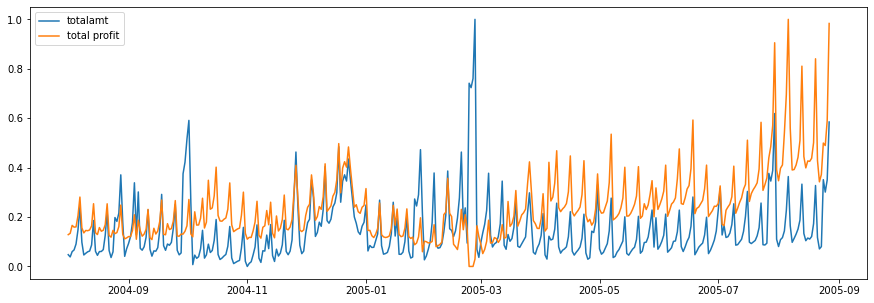

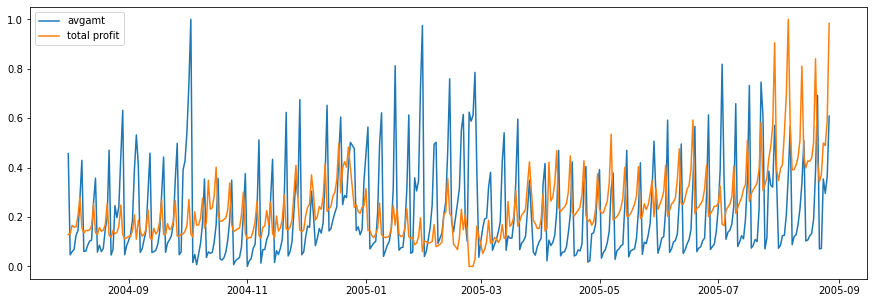

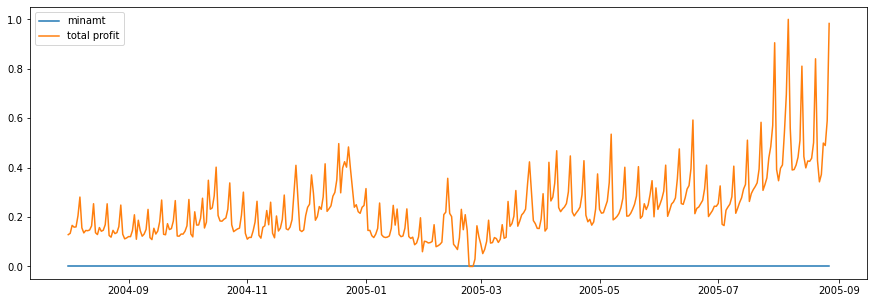

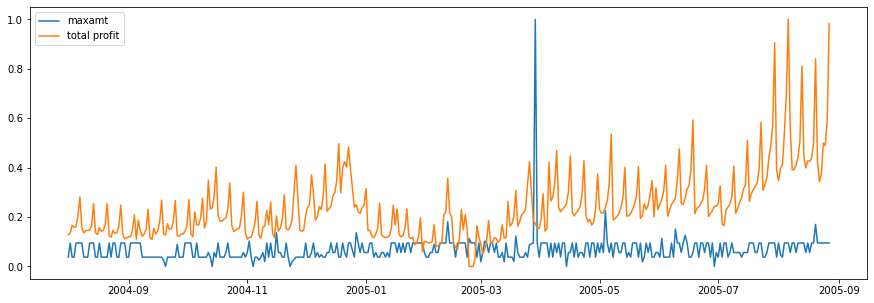

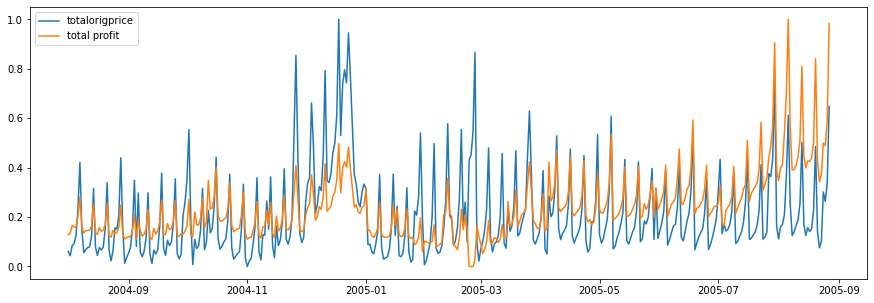

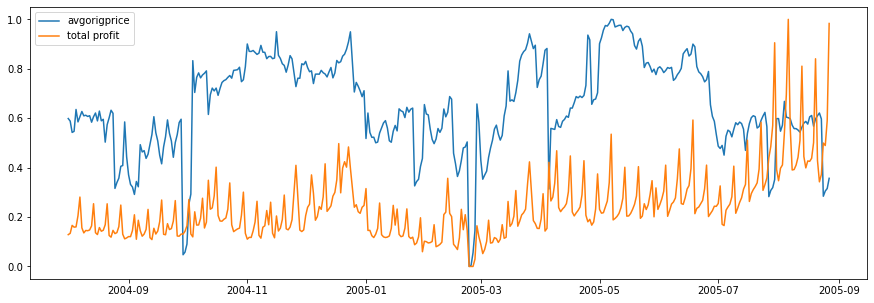

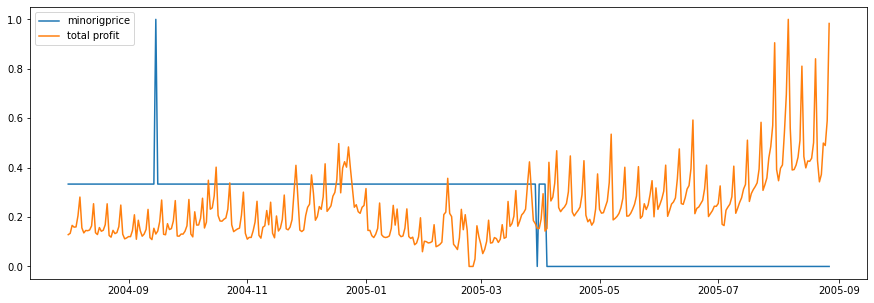

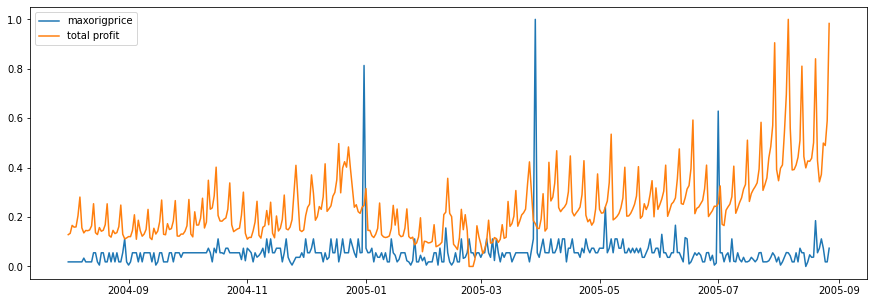

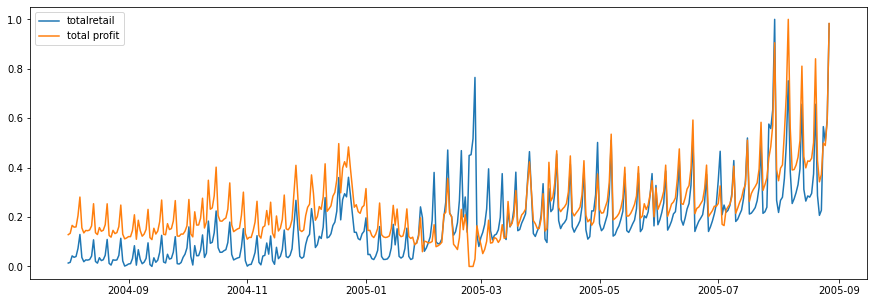

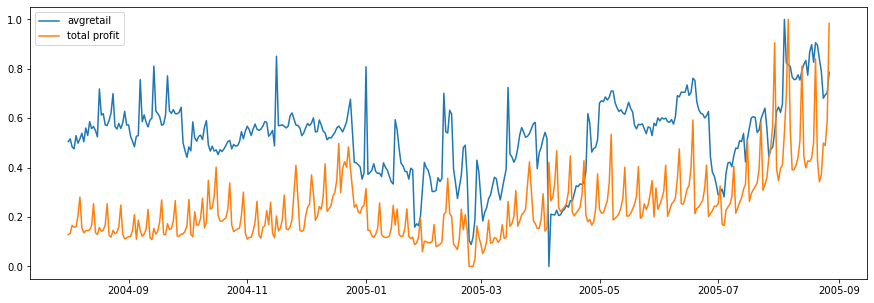

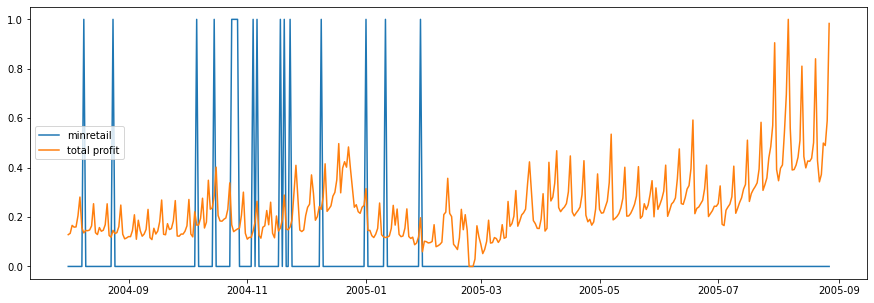

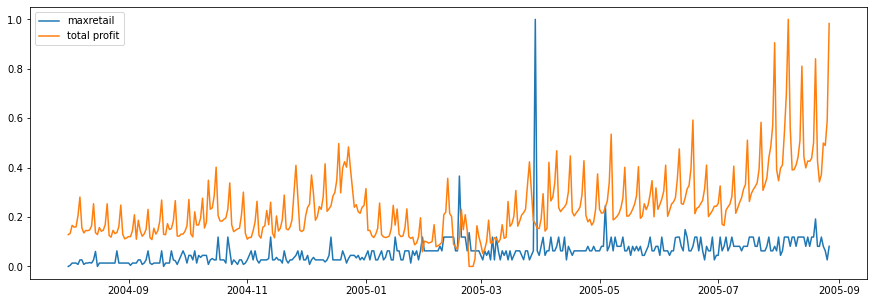

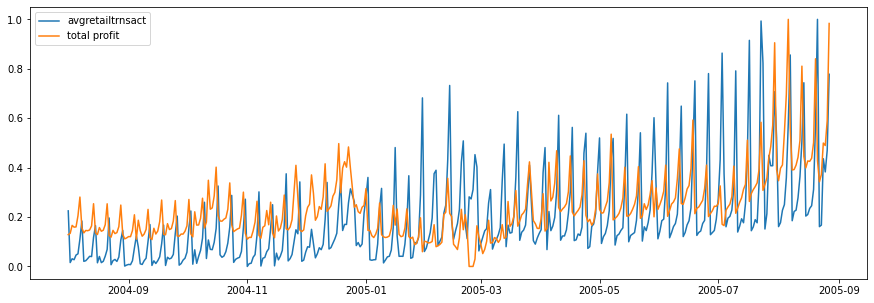

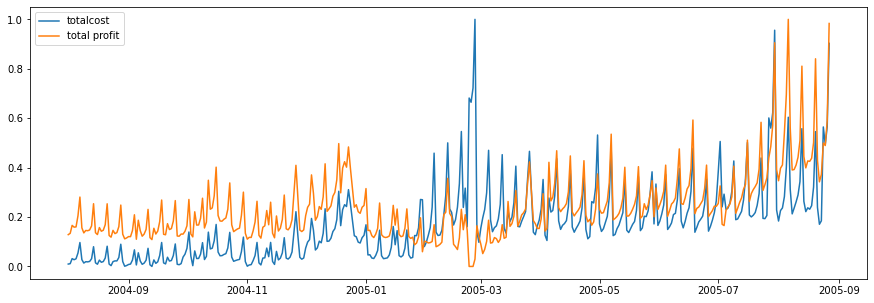

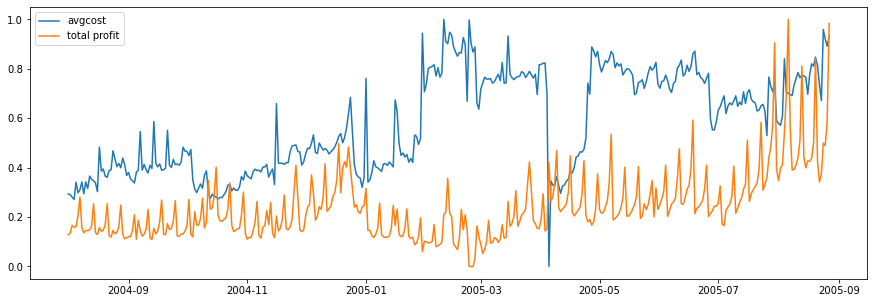

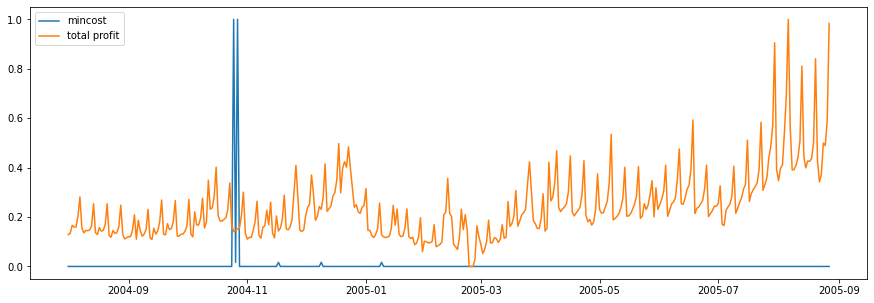

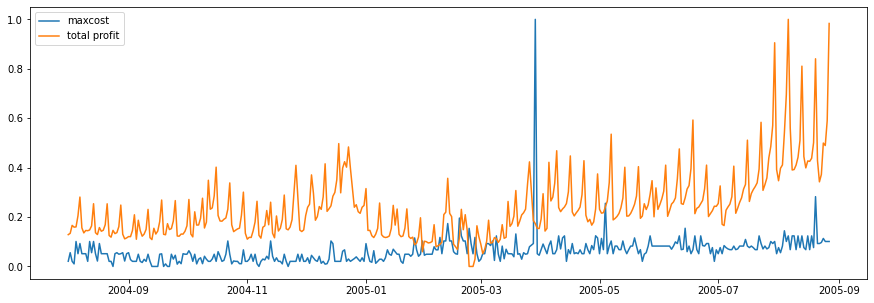

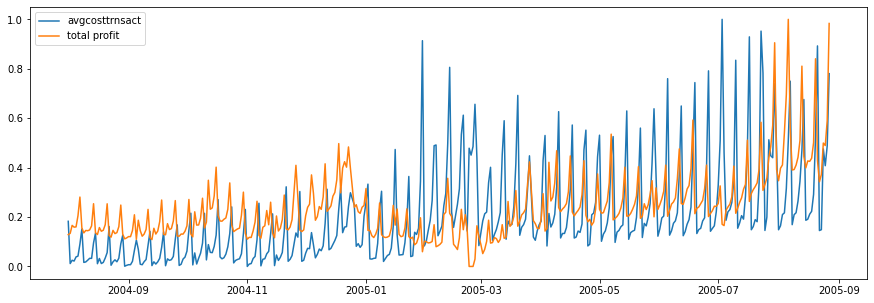

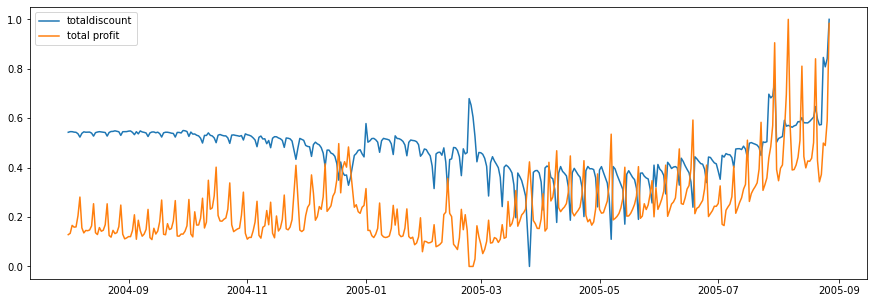

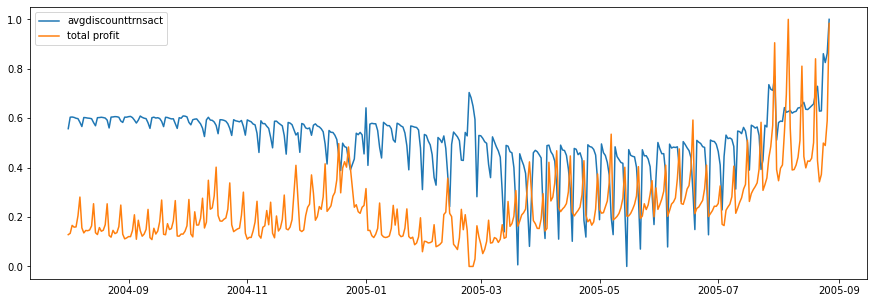

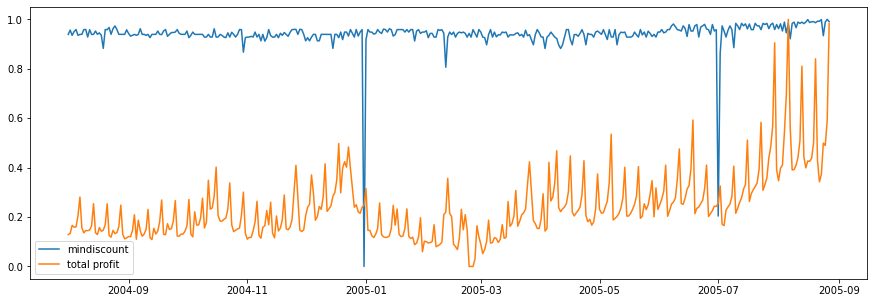

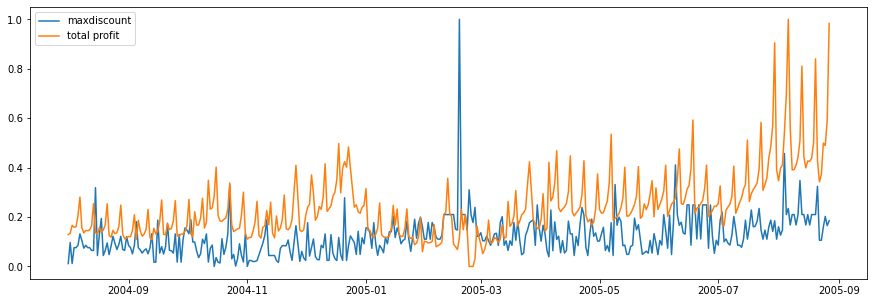

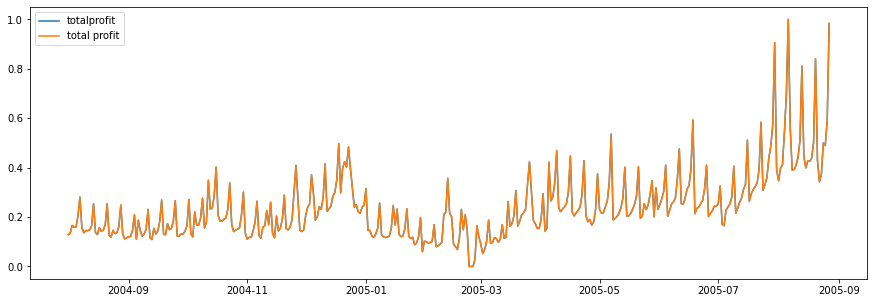

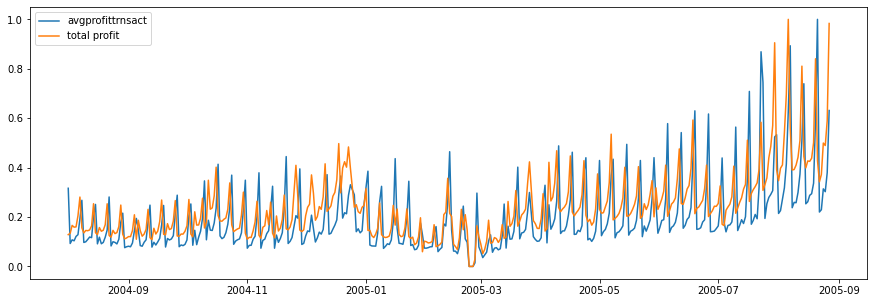

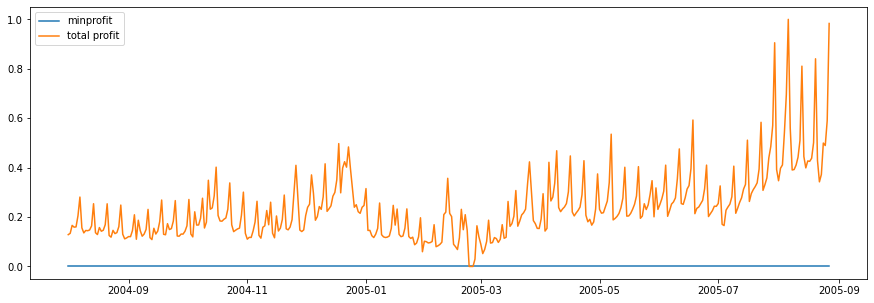

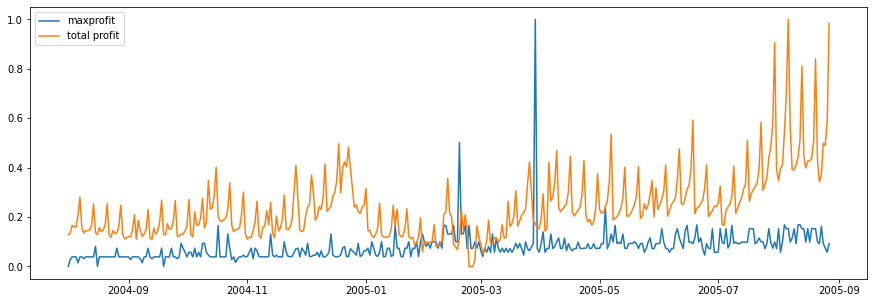

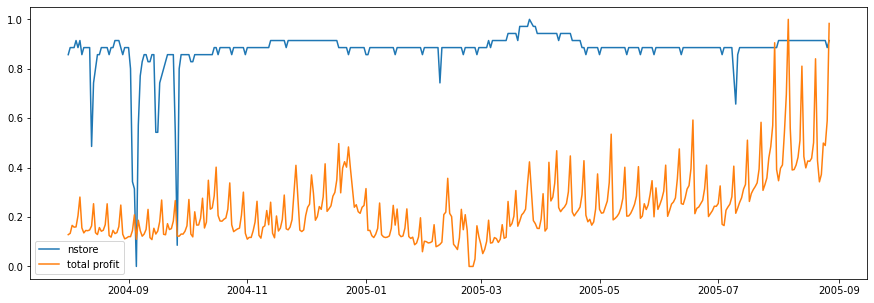

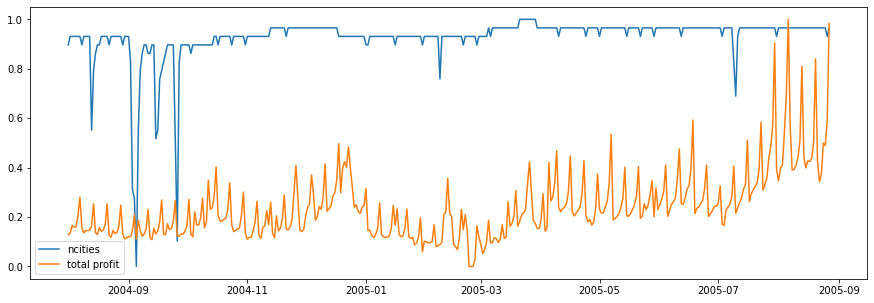

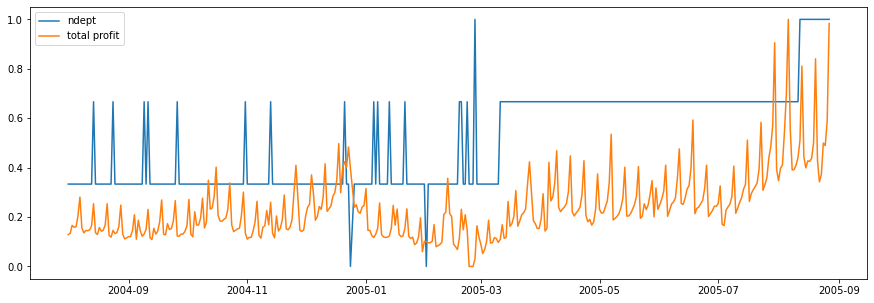

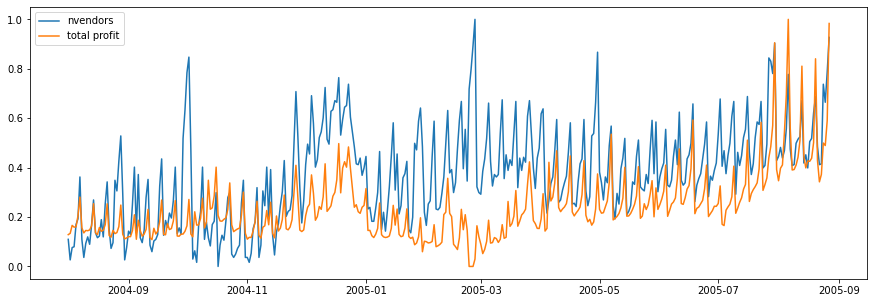

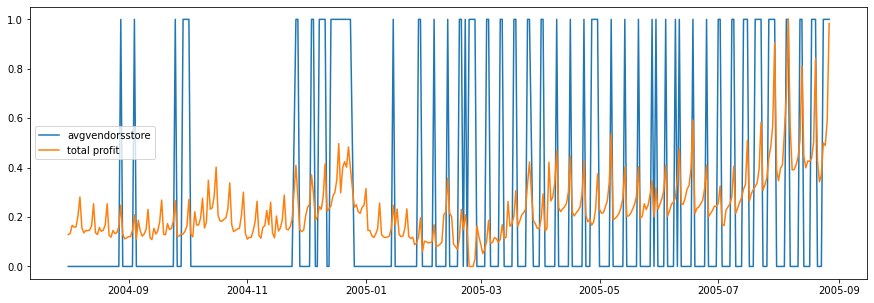

In [4]:
# normalize data for feature selection

df_viz = df
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
mc.fit(df_viz)
minMax = mc.transform(df_viz)
x_minmax = pd.DataFrame(minMax, columns = list(df_viz.columns))#.remove('totalprofit'))
x_minmax.index = df_viz.index


for i in list(x_minmax.columns):
    fig, ax = plt.subplots(figsize=(15, 5))

#     plt.figure()
    plt.plot(x_minmax[i])
    plt.plot(x_minmax.totalprofit)
    plt.legend([i,'total profit'])
    
    plt.show()
    

In [5]:
original_features = df.columns
original_features.drop('totalprofit')
original_features

Index(['nstores', 'nsku', 'totalquantity', 'avgquantity', 'totalamt', 'avgamt',
       'minamt', 'maxamt', 'totalorigprice', 'avgorigprice', 'minorigprice',
       'maxorigprice', 'totalretail', 'avgretail', 'minretail', 'maxretail',
       'avgretailtrnsact', 'totalcost', 'avgcost', 'mincost', 'maxcost',
       'avgcosttrnsact', 'totaldiscount', 'avgdiscounttrnsact', 'mindiscount',
       'maxdiscount', 'totalprofit', 'avgprofittrnsact', 'minprofit',
       'maxprofit', 'nstore', 'ncities', 'ndept', 'nvendors',
       'avgvendorsstore'],
      dtype='object')

In [6]:
# TODO: add lags
lag_list = []
def create_lag_feature(df, column):
    '''
    Create time lagging features
    '''
#     df = df.copy()
    average_value = np.mean(df[column])
    df[column + '_1'] = df[column].shift(1,fill_value = average_value)
    df[column + '_2'] = df[column].shift(2,fill_value = average_value)
    df[column + '_3'] = df[column].shift(3,fill_value = average_value)
    df[column + '_4'] = df[column].shift(4,fill_value = average_value)
    df[column + '_5'] = df[column].shift(5,fill_value = average_value)
    df[column + '_6'] = df[column].shift(6,fill_value = average_value)
    df[column + '_7'] = df[column].shift(7,fill_value = average_value)
    df[column + '_14'] = df[column].shift(14,fill_value = average_value)
    df[column + '_28'] = df[column].shift(28,fill_value = average_value)
    lag_list.append(column + '_1')
    lag_list.append(column + '_2')
    lag_list.append(column + '_3')
    lag_list.append(column + '_4')
    lag_list.append(column + '_5')
    lag_list.append(column + '_6')
    lag_list.append(column + '_7')
    lag_list.append(column + '_14')
    lag_list.append(column + '_28')

    return df

df_lag = df.copy()
for col in original_features:
    create_lag_feature(df_lag, col)
    
df_lag.drop(original_features, axis=1, inplace=True)


/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_28'] = df[column].shift(28,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_1'] = df[column].shift(1,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is 

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_28'] = df[column].shift(28,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_1'] = df[column].shift(1,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is 

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_2'] = df[column].shift(2,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_3'] = df[column].shift(3,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is u

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_1'] = df[column].shift(1,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_2'] = df[column].shift(2,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is us

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_1'] = df[column].shift(1,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_2'] = df[column].shift(2,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is us

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_3'] = df[column].shift(3,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_4'] = df[column].shift(4,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is u

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_4'] = df[column].shift(4,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_5'] = df[column].shift(5,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is u

/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_5'] = df[column].shift(5,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_6'] = df[column].shift(6,fill_value = average_value)
/var/folders/j2/sdx7xgy560748vt327rz93pc0000gn/T/ipykernel_54830/243883705.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is u

In [7]:
df_lag.head(5)


,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,89270.339332,...,931.768638,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-02,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,61741.000000,...,931.768638,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-03,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,59183.000000,...,931.768638,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-04,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,62593.000000,...,931.768638,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-05,324.000000,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,65689.000000,...,931.768638,2.000000,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933


In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    return df
# create time series features
df_lag_ts = create_features(df_lag)


In [9]:
df_lag_ts.head()

,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28,hour,dayofweek,quarter,month,year,dayofmonth
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,89270.339332,...,2.233933,2.233933,2.233933,2.233933,0,6,3,8,2004,1
2004-08-02,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,61741.000000,...,2.233933,2.233933,2.233933,2.233933,0,0,3,8,2004,2
2004-08-03,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,59183.000000,...,2.233933,2.233933,2.233933,2.233933,0,1,3,8,2004,3
2004-08-04,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,62593.000000,...,2.233933,2.233933,2.233933,2.233933,0,2,3,8,2004,4
2004-08-05,324.000000,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,65689.000000,...,2.233933,2.233933,2.233933,2.233933,0,3,3,8,2004,5


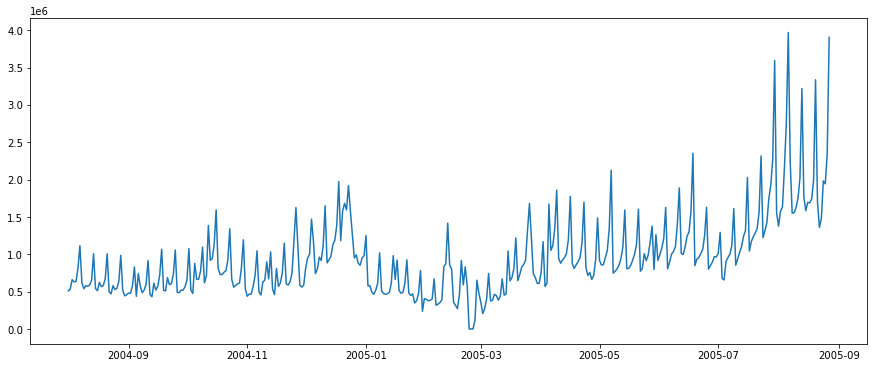

In [10]:
#visualize total profit
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df.totalprofit)
plt.show()


In [11]:
#normalize x variables
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
mc.fit(df_lag_ts)
minMax = mc.transform(df_lag_ts)
x_minmax = pd.DataFrame(minMax, columns = list(df_lag_ts.columns))
x_minmax.index = df_lag_ts.index

df_norm = x_minmax.join(pd.DataFrame(df['totalprofit']))
df_norm


,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28,hour,dayofweek,quarter,month,year,dayofmonth,totalprofit
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.299374,...,0.233933,0.233933,0.233933,0.0,1.000000,0.666667,0.636364,0.0,0.000000,511060.0
2004-08-02,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.093604,...,0.233933,0.233933,0.233933,0.0,0.000000,0.666667,0.636364,0.0,0.033333,532033.0
2004-08-03,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.074484,...,0.233933,0.233933,0.233933,0.0,0.166667,0.666667,0.636364,0.0,0.066667,659895.0
2004-08-04,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.099972,...,0.233933,0.233933,0.233933,0.0,0.333333,0.666667,0.636364,0.0,0.100000,631430.0
2004-08-05,0.885714,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.123114,...,0.233933,0.233933,0.233933,0.0,0.500000,0.666667,0.636364,0.0,0.133333,635209.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.271252,...,0.000000,0.000000,0.000000,0.0,0.166667,0.666667,0.636364,1.0,0.733333,1477840.0
2005-08-24,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.267448,...,0.000000,0.000000,1.000000,0.0,0.333333,0.666667,0.636364,1.0,0.766667,1982620.0
2005-08-25,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.685291,...,1.000000,0.000000,1.000000,0.0,0.500000,0.666667,0.636364,1.0,0.800000,1943150.0


In [12]:
#split train and test data
train = df_norm[(df_norm.index.get_level_values(0) >= '2004-08-01') & (df_norm.index.get_level_values(0) <= '2005-05-01')]
test = df_norm[(df_norm.index.get_level_values(0) > '2005-05-01')]


In [13]:
train.head(5)

,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28,hour,dayofweek,quarter,month,year,dayofmonth,totalprofit
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.299374,...,0.233933,0.233933,0.233933,0.0,1.000000,0.666667,0.636364,0.0,0.000000,511060.0
2004-08-02,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.093604,...,0.233933,0.233933,0.233933,0.0,0.000000,0.666667,0.636364,0.0,0.033333,532033.0
2004-08-03,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.074484,...,0.233933,0.233933,0.233933,0.0,0.166667,0.666667,0.636364,0.0,0.066667,659895.0
2004-08-04,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.099972,...,0.233933,0.233933,0.233933,0.0,0.333333,0.666667,0.636364,0.0,0.100000,631430.0
2004-08-05,0.885714,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.123114,...,0.233933,0.233933,0.233933,0.0,0.500000,0.666667,0.636364,0.0,0.133333,635209.0


### Initialize the auto arima function


In [14]:
import pmdarima as pm

# SARIMAX Model
# input x exogenous variables with lag 1 because they show correlation with total profit.

exovars = ['nsku_1',
        'totalquantity_1',
        'avgquantity_1',
        'totalamt_1',
        'avgamt_1',
        'totalorigprice_1',
        'avgorigprice_1',
        'totalretail_1',
        'avgretailtrnsact_1',
        'totalcost_1',
        'avgcosttrnsact_1',
        'avgprofittrnsact_1',
           'dayofweek',
           'dayofmonth',
           'quarter',
           'month']
sxmodel = pm.auto_arima(train[['totalprofit']], exogenous=train[exovars],
                           start_p=1, start_q=1, start_d=1,
                           test='adf',
                           max_p=5, max_q=5, max_d=5,
                           max_P=5, max_Q=5, max_D=5,
                           m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=7324.374, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7487.577, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7385.119, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7331.201, Time=0.70 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=7322.547, Time=1.02 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=7353.786, Time=0.84 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=7324.494, Time=7.92 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=7324.387, Time=10.99 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,2)[12]             : AIC=7322.399, Time=5.14 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,3)[12]             : AIC=7324.392, Time=8.23 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=7326.296, Time=8.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=7327.907, Time=3.95 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,2)[12]             : AIC=7345.742, Time=3.38 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=7303.328, Time=7.53 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=7304.853, Time=1.11 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=7305.315, Time=13.28 sec
 ARIMA(2,1,1)(0,1,3)[12]             : AIC=7305.322, Time=10.21 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=7303.435, Time=1.20 sec
 ARIMA(2,1,1)(1,1,3)[12]             : AIC=7307.229, Time=10.15 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=7314.998, Time=4.75 sec
 ARIMA(3,1,1)(0,1,2)[12]             : AIC=7304.791, Time=9.44 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=7299.464, Time=10.81 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=7300.362, Time=1.21 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=7301.433, Time=16.91 sec
 ARIMA(2,1,2)(0,1,3)[12]             : AIC=7301.447, Time=16.21 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=7299.577, Time=1.79 sec
 ARIMA(2,1,2)(1,1,3)[12]             : AIC=7303.409, Tim

/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=7299.905, Time=6.51 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,1,2)[12]             : AIC=7299.952, Time=16.42 sec
 ARIMA(2,1,3)(0,1,2)[12]             : AIC=7288.730, Time=17.88 sec
 ARIMA(2,1,3)(0,1,1)[12]             : AIC=7287.060, Time=1.77 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=7360.235, Time=0.52 sec
 ARIMA(2,1,3)(1,1,1)[12]             : AIC=7288.836, Time=2.14 sec
 ARIMA(2,1,3)(1,1,0)[12]             : AIC=7321.706, Time=1.73 sec
 ARIMA(2,1,3)(1,1,2)[12]             : AIC=inf, Time=31.72 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,1,1)[12]             : AIC=7325.123, Time=1.54 sec
 ARIMA(3,1,3)(0,1,1)[12]             : AIC=7271.563, Time=2.22 sec
 ARIMA(3,1,3)(0,1,0)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(3,1,3)(1,1,1)[12]             : AIC=7273.544, Time=2.57 sec
 ARIMA(3,1,3)(0,1,2)[12]             : AIC=7273.535, Time=17.64 sec
 ARIMA(3,1,3)(1,1,0)[12]             : AIC=7317.187, Time=1.99 sec
 ARIMA(3,1,3)(1,1,2)[12]             : AIC=inf, Time=27.20 sec


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,1,1)[12]             : AIC=7300.969, Time=1.85 sec
 ARIMA(4,1,3)(0,1,1)[12]             : AIC=7268.534, Time=2.61 sec
 ARIMA(4,1,3)(0,1,0)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(4,1,3)(1,1,1)[12]             : AIC=7270.504, Time=3.37 sec
 ARIMA(4,1,3)(0,1,2)[12]             : AIC=7270.490, Time=25.16 sec
 ARIMA(4,1,3)(1,1,0)[12]             : AIC=7315.802, Time=3.39 sec
 ARIMA(4,1,3)(1,1,2)[12]             : AIC=inf, Time=38.99 sec
 ARIMA(4,1,2)(0,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(5,1,3)(0,1,1)[12]             : AIC=7242.874, Time=3.50 sec
 ARIMA(5,1,3)(0,1,0)[12]             : AIC=7320.566, Time=1.18 sec
 ARIMA(5,1,3)(1,1,1)[12]             : AIC=7244.774, Time=3.98 sec
 ARIMA(5,1,3)(0,1,2)[12]             : AIC=7244.741, Time=34.11 sec
 ARIMA(5,1,3)(1,1,0)[12]             : AIC=7278.823, Time=3.74 sec
 ARIMA(5,1,3)(1,1,2)[12]             : AIC=inf, Time=37.96 sec
 ARIMA(5,1,2)(0,1,1)[12]             : AIC=7236.810, Time=2.60 sec
 ARIMA(5,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  271
Model:             SARIMAX(5, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -3609.405
Date:                              Mon, 05 Dec 2022   AIC                           7236.810
Time:                                      09:02:39   BIC                           7268.787
Sample:                                           0   HQIC                          7249.668
                                              - 271                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4005      0.125      3.211      0.001       0.156       0.645
ar.L2         -0.7096      0.137     -5.193      0.000      -0.977      -0.442
ar.L3         -0.2318      0.154     -1.502      0.133      -0.534       0.071
ar.L4         -0.3099      0.140     -2.218      0.027      -0.584      -0.036
ar.L5         -0.3023      0.132     -2.283      0.022      -0.562      -0.043
ma.L1         -0.9806      0.095    -10.343      0.000      -1.166      -0.795
ma.L2          0.8219      0.106      7.753      0.000       0.614       1.030
ma.S.L12      -0.8675      0.081    -10.732      0.000      -1.026      -0.709
sigma2      1.238e+11   1.21e-12   1.02e+23      0.000    1.24e+11    1.24e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.67
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+38. Standard errors may be unstable.
"""

### Fitting the SARIMAX model

In [15]:
sxmodel.fit(train['totalprofit'],X=train[exovars])

ARIMA(order=(5, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Using the SARIMAX model to make predictions

In [16]:
forecast = sxmodel.predict(n_periods=118, return_conf_int=True, X=test[exovars])
forecast_df = pd.DataFrame(forecast[0],columns=['Prediction'])
forecast_df['saledate'] = test.index
forecast_df = forecast_df.set_index('saledate')

forecast


/Users/xinshu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(271    1.098962e+06
 272    1.238377e+06
 273    1.074794e+06
 274    1.249076e+06
 275    1.138724e+06
            ...     
 384    9.363841e+05
 385    8.906128e+05
 386    5.696022e+05
 387    7.016436e+05
 388    6.751909e+05
 Length: 118, dtype: float64,
 array([[ 3.66368371e+05,  1.83155638e+06],
        [ 3.07383097e+05,  2.16937133e+06],
        [ 3.27525469e+04,  2.11683540e+06],
        [ 1.30695537e+05,  2.36745668e+06],
        [-3.55146204e+03,  2.28099880e+06],
        [-1.48175496e+05,  2.25941471e+06],
        [-7.04288366e+05,  1.77695759e+06],
        [-3.14232878e+05,  2.29486675e+06],
        [-2.30936561e+05,  2.47809147e+06],
        [-2.10681344e+05,  2.59743447e+06],
        [-1.14297260e+05,  2.79154537e+06],
        [-2.28819811e+05,  2.75861872e+06],
        [-2.91562386e+05,  2.84099095e+06],
        [-5.40152654e+05,  2.70726489e+06],
        [-6.36771649e+05,  2.72394082e+06],
        [-4.68164472e+05,  2.99345109e+06],
        [-5.59512512e+05,  2.991012

### Plotting the Pandas data frame

In [17]:
import matplotlib.pyplot as plt

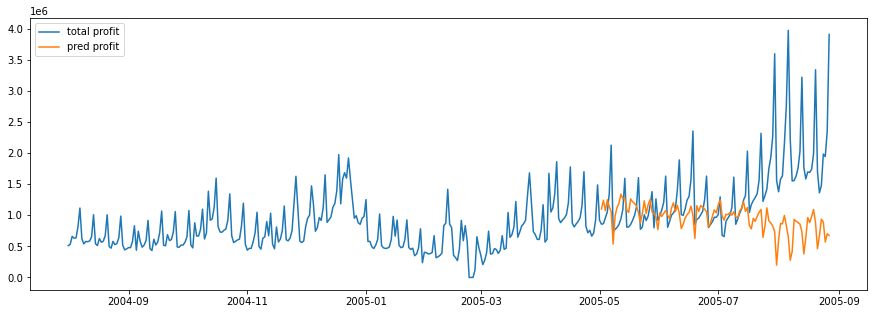

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_norm['totalprofit'])
plt.plot(forecast_df)
plt.legend(['total profit','pred profit'])
plt.show()
    
# pd.concat([df_ts['totalprofit'],forecast_df],axis=1).plot()

### model evaluation

In [19]:
import sklearn.metrics as metrics
def arima_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [20]:
y_test = test['totalprofit']
y_pred = forecast_df['Prediction']
arima_results(y_test, y_pred)


explained_variance:  -0.3523
r2:  -0.8068
MAE:  559029.0761
MSE:  741552004813.9507
RMSE:  861134.1387
